<a href="https://colab.research.google.com/github/francobarrionuevoenv21/HPC_2025/blob/main/CA_Implt_GPUs_HPC2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=61cc3c67aa1b20553b40ba1a500bd6e0ca573a1c55f7acc243f55f1c2ce82476
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [2]:
# PYCUDA LIBRARIES
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [100]:
# GENERAL PURPOSES LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import time

## Input data

In [143]:
# INPUT DATA DIMENSIONS
x = 64
y = 64

### NDVI

In [144]:
NDVI_random = np.full((y, x), 0.8, dtype= np.float32)

### Cell state

In [145]:
state = np.zeros((y, x), dtype=np.int32)  # 0: non-burnt, 1: burning & 2: burnt

## NDVI data processing

In [146]:
def calculate_p_den(water_thres, low_thres, high_thres, NDVI):
    water_value = 'water'
    low_value = 'nonflammable'
    mid_value = 'medium'
    high_value = 'dense'

    # Initialize ndvi_grouped with a default value or array
    #ndvi_grouped = np.empty_like(NDVI, dtype='<U10') # Using string dtype to hold the category names

    ndvi_grouped = np.where(NDVI >= high_thres, high_value, NDVI)
    ndvi_grouped = np.where((NDVI >= low_thres) & (NDVI < high_thres), mid_value, ndvi_grouped)
    ndvi_grouped = np.where((NDVI >= water_thres) & (NDVI < low_thres), low_value, ndvi_grouped)
    # The original code had this condition last, let's keep it for water
    ndvi_grouped = np.where(NDVI < water_thres, water_value, ndvi_grouped)


    return ndvi_grouped

def calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped):
    p_den = np.zeros_like(ndvi_grouped, dtype=float)  # numeric array

    p_den[ndvi_grouped == 'water'] = den_water
    p_den[ndvi_grouped == 'nonflammable'] = den_low
    p_den[ndvi_grouped == 'medium'] = den_mid
    p_den[ndvi_grouped == 'dense'] = den_high

    return p_den

In [147]:
ndvi= NDVI_random
water_thres = 0.1
low_thres = 0.5
high_thres = 0.7

den_water = -1 # Using negative values for water to ensure it can't be enflamed
den_low = -1 # These are nonflammable areas
den_mid = 0 # These are the general areas
den_high = 0.2 # Dense areas have increased change of spreading

In [148]:
# FIRE PROBABILITY BY NDVI VALUE

# Let's group the NDVI using the first function
ndvi_grouped = calculate_p_den(water_thres, low_thres, high_thres, ndvi)

# p_den DATA GENERATION
'''p_den is the one that will actually be used for calculation. Not that water and nonflammable are both -1, i.e.,
nonflammable. Otherwise, the more vegetation the higher the burn probability'''
p_den = calculate_p_den_values(den_water, den_low, den_mid, den_high, ndvi_grouped).astype(np.float32)

In [149]:
p_den

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]], dtype=float32)

In [150]:
'''cmap_123 = ListedColormap(['darkgreen']) # ['blue', 'goldenrod', 'limegreen', 'darkgreen']
plt.imshow(p_den, cmap=cmap_123)
plt.show()'''

"cmap_123 = ListedColormap(['darkgreen']) # ['blue', 'goldenrod', 'limegreen', 'darkgreen']\nplt.imshow(p_den, cmap=cmap_123)\nplt.show()"

## Set initial conditions

### Fire start point

In [151]:

FP_lon_index = int(x/2)
FP_lat_index = int(y/2)

state[FP_lon_index, FP_lat_index] = 1

In [51]:
#state

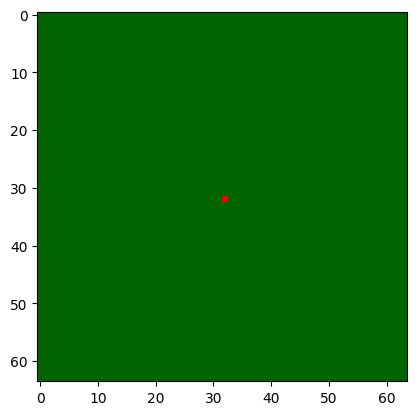

In [152]:
cmap_123 = ListedColormap(['darkgreen', 'red']) # ['blue', 'goldenrod', 'limegreen', 'darkgreen']
plt.imshow(state, cmap=cmap_123)
plt.show()

### Burn probability threshold

In [153]:
p_h = 0.6 # This parameter should be tunned in future instances
p_burn = p_h*(1+p_den) # p_burn is larger as higher the ndvi value (more biomass can be serve as fuel)

In [54]:
#p_burn

### Set iterations (time-steps)

In [176]:
# NUMBER OF TIME-STEPS
T = 20

# SET RANDOM VALUES MATRIX (ONLY FOR GPU IMPLEMENTATION)
random_p = np.random.rand(T, x, y).astype(np.float32)

## AC GPU implementation

In [177]:
state_GPU = state.copy()

### AC implementation Kernel

In [178]:
mod = SourceModule ("""
    __global__ void compute_AC(int *state, float *ndvi, float *randm, int rows, int cols){
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        int i = row * cols + col;

        if (state[i] == 2){
              state[i] = 2;
        } else if (
            (row > 0 && state[i - cols] == 1) || // Up
            (row < rows-1 && state[i + cols] == 1) || // Down
            (col > 0 && state[i - 1] == 1) || // Left
            (col < cols-1 && state[i + 1] == 1) || // Right
            (row > 0 && col > 0 && state[i - cols - 1] == 1) || // Up-left
            (row > 0 && col < cols-1 && state[i - cols + 1] == 1) || // Up-right
            (row < rows-1 && col > 0 && state[i + cols - 1] == 1) || // Down-left
            (row < rows-1 && col < cols-1 && state[i + cols + 1] == 1) // Down-right
        ) {

          if (randm[i] < ndvi[i]) {
            state[i] = 1;
          } else {
            state[i] = 0;
          }
        } else if (state[i] == 1) {
            state[i] = 2;
        } else {
          state[i] = 0;
        }
      }
    }
    """)

### -

In [179]:
# DEFINE ROWS AND COLS
cols = x
rows = y

# START TIME GPU IMPLEMENTATION
start_GPU = time.time()

# GET THE KERNEL FUNCTION
compute_AC = mod.get_function("compute_AC")

# ALLOCATE GPU MEMORY
state_gpu = drv.mem_alloc(state.nbytes)
state_old_gpu = drv.mem_alloc(state.nbytes)
ndvi_gpu = drv.mem_alloc(ndvi.nbytes)
randm_gpu = drv.mem_alloc(random_p[0].nbytes)

# Copy initial data to GPU
drv.memcpy_htod(state_gpu, state_GPU)
drv.memcpy_htod(ndvi_gpu, ndvi)

# Define block and grid dimensions
block_dim = (32, 32, 1) # max threads by block: 1024 (32x32)
grid_dim = ((cols + block_dim[0] - 1) // block_dim[0],
           (rows + block_dim[1] - 1) // block_dim[1], 1)

# Time loop
for t in range(T):

    '''# Copy current state to old state
    drv.memcpy_dtod(state_old_gpu, state_gpu, state.nbytes)'''

    # Generate new random values for this iteration (if needed)
    #random_p = np.random.random((rows, cols)).astype(np.float32)
    drv.memcpy_htod(randm_gpu, random_p[t])

    # Launch kernel
    compute_AC(
        state_gpu,
        ndvi_gpu,
        randm_gpu,
        np.int32(rows),
        np.int32(cols),
        block=block_dim,
        grid=grid_dim
    )

    '''# Copy current state to old state
    drv.memcpy_dtod(state_old_gpu, state_gpu, state.nbytes)'''

    '''# Optional: Copy back and print intermediate results
    if t % 1 == 0:  # Print every iteration
        temp_result = np.empty_like(state)
        drv.memcpy_dtoh(temp_result, state_gpu)
        print(f"Iteration {t}:")
        print(temp_result)
        print()'''

    # Copy current state to old state
    drv.memcpy_dtod(state_old_gpu, state_gpu, state.nbytes)


# Copy final result back to CPU
result = np.empty_like(state)
drv.memcpy_dtoh(result, state_gpu)

# END TIME GPU IMPLEMENTATION
end_GPU = time.time()

#print("Final result:")
#print(result)

In [180]:
end_GPU-start_GPU # in seconds

0.0033588409423828125

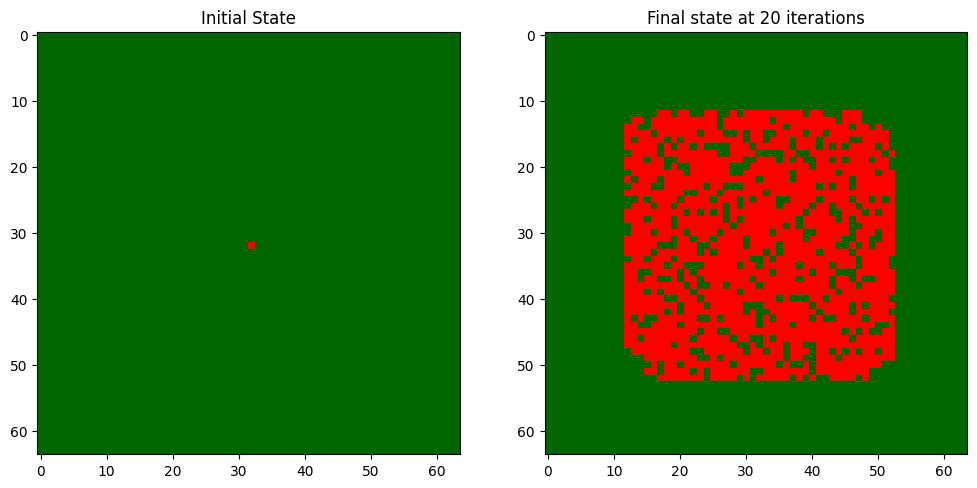

In [181]:
cmap_123 = ListedColormap(['darkgreen', 'red'])

fig, ax = plt.subplots(1, 2, figsize=(12,12)) # Correctly unpacks figure and axes

ax[0].imshow(state_GPU, cmap=cmap_123) # Use the first axes for the initial state
ax[0].set_title("Initial State")
ax[1].imshow(result, cmap=cmap_123) # Use the second axes for the final state
ax[1].set_title("Final state at "+str(T)+" iterations")
plt.show()

## AC Sequential implementation ()

In [192]:
state_Seq = state.copy()

In [193]:
# START TIME SEQ IMPLEMENTATION
start_SEQ = time.time()

for i_t in range(T):
    new_state = state_Seq.copy()  # buffer for the new step
    for i in range(y):
        for j in range(x):
            if state_Seq[i, j] == 2:
                new_state[i, j] = 2
            elif (i + 1 < y and state_Seq[i+1, j] == 1) or \
                 (i - 1 >= 0 and state_Seq[i-1, j] == 1) or \
                 (j + 1 < x and state_Seq[i, j+1] == 1) or \
                 (j - 1 >= 0 and state_Seq[i, j-1] == 1) or \
                 (i + 1 < y and j + 1 < x and state_Seq[i+1, j+1] == 1) or \
                 (i - 1 >= 0 and j - 1 >= 0 and state_Seq[i-1, j-1] == 1) or \
                 (i + 1 < y and j - 1 >= 0 and state_Seq[i+1, j-1] == 1) or \
                 (i - 1 >= 0 and j + 1 < x and state_Seq[i-1, j+1] == 1):
                if np.random.rand() < p_burn[i, j]:
                    new_state[i, j] = 1
                else:
                    new_state[i, j] = 0
            elif state_Seq[i, j] == 1:
                new_state[i, j] = 2
            else:
                new_state[i, j] = 0
    state_Seq = new_state  # update after the full step

# START TIME SEQ IMPLEMENTATION
end_SEQ = time.time()

In [195]:
end_SEQ-start_SEQ

0.23138642311096191

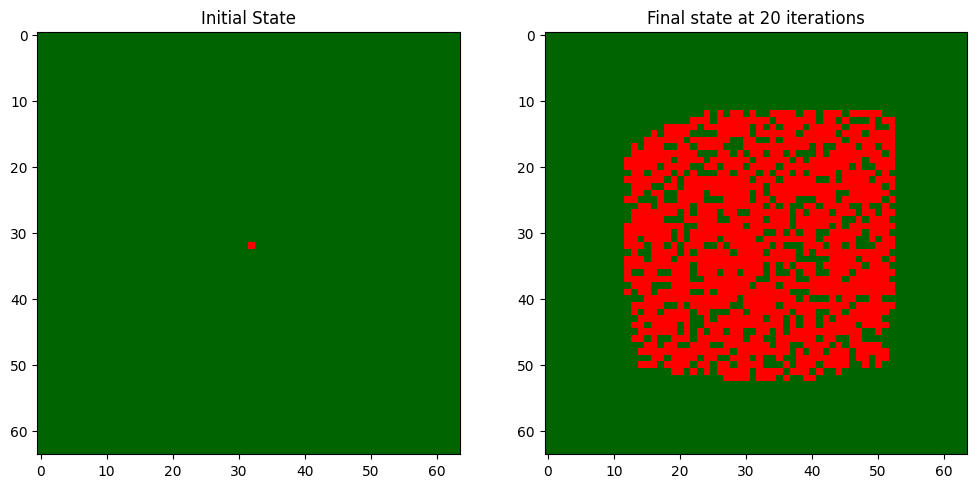

In [194]:
cmap_123 = ListedColormap(['darkgreen', 'red'])

fig, ax = plt.subplots(1, 2, figsize=(12,12)) # Correctly unpacks figure and axes

ax[0].imshow(state_GPU, cmap=cmap_123) # Use the first axes for the initial state
ax[0].set_title("Initial State")
ax[1].imshow(state_Seq, cmap=cmap_123) # Use the second axes for the final state
ax[1].set_title("Final state at "+str(T)+" iterations")
plt.show()

## WIND DATA

In [ ]:
U = np.full((y, x), 1.0)   # x-component
V = np.full((y, x), 1.0)   # y-component

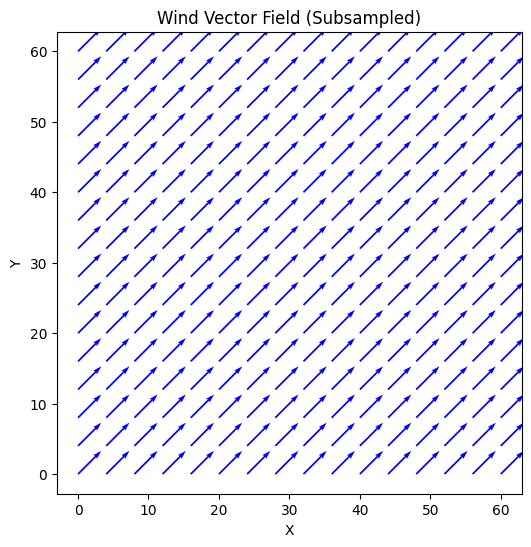

In [ ]:
X, Y = np.meshgrid(np.arange(x), np.arange(x))

# PLOT WIND DATA SUBSAMPLE
plt.figure(figsize=(6,6))
plt.quiver(
    X[::step, ::step],
    Y[::step, ::step],
    U[::step, ::step],
    V[::step, ::step],
    scale=20,
    color="blue"
)

'''plt.quiver(
    X,
    Y,
    U,
    V,
    scale=20,
    color="blue"
)'''
plt.title("Wind Vector Field (Subsampled)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(30, 90)
plt.ylim(0, 90)
plt.axis("equal")
plt.show()

In [ ]:
n_t = 3 # timesteps

# fire_state = timesteps x lat x lon
fire_state = np.zeros((n_t, y, x), dtype=int)

In [ ]:
#p_burn = p_h * (1+p_den) # probability of burning
p_h = 0.6
p_burn = p_h*(1+p_den)

In [ ]:
p_burn

array([[0.72, 0.72, 0.  , ..., 0.  , 0.72, 0.6 ],
       [0.  , 0.6 , 0.  , ..., 0.72, 0.72, 0.  ],
       [0.72, 0.72, 0.72, ..., 0.  , 0.72, 0.  ],
       ...,
       [0.72, 0.  , 0.72, ..., 0.72, 0.  , 0.  ],
       [0.  , 0.72, 0.72, ..., 0.72, 0.6 , 0.72],
       [0.72, 0.  , 0.  , ..., 0.72, 0.  , 0.6 ]])

In [ ]:
#fire_state

In [ ]:
U[34][45], V[34][45]

(np.float64(1.0), np.float64(1.0))

In [ ]:
a = np.array([U[34][45], V[34][45]])
b = np.array([-1, 0])

def same_direction(A, B):
  dot = np.dot(A, B)
  norm = np.linalg.norm(A) * np.linalg.norm(B)
  cos_theta = dot / norm
  return cos_theta

same_direction(a, b)

np.float64(-0.7071067811865475)

In [ ]:
for i_t in range(1,n_t):
    for i in range(len(x)):
        for j in range(len(y)):
            # If cell is burnt it remains burnt
            if fire_state[i_t-1, i, j] == 2:
                fire_state[i_t, i, j] = 2
            # If cell was burning it turns into a burnt cell
            elif fire_state[i_t-1, i, j] == 1:
                fire_state[i_t, i, j] = 2
            # If cell is not burning and adjacent cell is burning, calculate if it turns to burning cell
            elif (i+1 < len(x) and fire_state[i_t-1, i+1, j] == 1) or \ # right pixel
               (i-1 >= 0 and fire_state[i_t-1, i-1, j] == 1) or \ # left pixel
               (j+1 < len(y) and fire_state[i_t-1, i, j+1] == 1) or \ # upper pixel
               (j-1 >= 0 and fire_state[i_t-1, i, j-1] == 1) or \ # lower pixel
               (i+1 < len(x) and j+1 < len(y) and fire_state[i_t-1, i+1, j+1] == 1) or \ # upper-right pixel
               (i-1 >= 0 and j-1 >= 0 and fire_state[i_t-1, i-1, j-1] == 1) or \ # lower-left pixel
               (i+1 < len(x) and j-1 >= 0 and fire_state[i_t-1, i+1, j-1] == 1) or \ # lower-right pixel
               (i-1 >= 0 and j+1 < len(y) and fire_state[i_t-1, i-1, j+1] == 1): # upper-left pixel
                if np.random.rand() < p_burn[i,j]:
                    fire_state[i_t, i, j] = 1
                else:
                    fire_state[i_t, i, j] = 0
            # All cells that are not burning and not adjacent to a burning cell remain unburnt
            else:
                fire_state[i_t, i, j] = fire_state[i_t-1, i, j]

# USELESS

In [ ]:
#  2D / 1 Block
#   doblar matriz
#   Implementación con SourceModule de duplicar elementos de una matriz.


!pip install pycuda

import pycuda.driver as drv
import pycuda.autoinit
from   pycuda.compiler import SourceModule
import numpy as np
import time


if __name__ == '__main__':

    # Parametros de configuracion:
    drv.init()
    dev = drv.Device(0) # Device 0
    max_thr_per_blk = dev.MAX_THREADS_PER_BLOCK
    print("MAX_THREADS_PER_BLOCK: ", max_thr_per_blk)

    # 1. Definir kenel
    mod = SourceModule ("""
    __global__ void doblar_matriz(float *a) {
        int row = (blockDim.x * blockIdx.x) + threadIdx.x;
        int col = (blockDim.y * blockIdx.y) + threadIdx.y;

        if ((row < 5) && (col < 5)) {
            int i = (row * 5) + col;   /* Row major */
            a[i] = a[i] * 2;
        }
    }
    """)

    # 2. Reserva memoria en GPU:
    H = 64
    W = 64
    a = np.arange(H * W, dtype=np.float32).reshape(H, W)
    print("Matriz:", a, a.nbytes)
    a_gpu = drv.mem_alloc(a.nbytes) # mem_alloc(size) asks the GPU to reserve size bytes in global memory

    # 3. Transferir datos host->GPU
    drv.memcpy_htod(a_gpu, a)

    # 4. Invoca kernel
    comp_AC = mod.get_function("compute_AC")
    comp_AC(a_gpu, block = (H, W, 1),
                  grid  = (1, 1, 1))

    # 5. Transferir datos GPU->host
    a_doubled = np.arange(H * W, dtype=np.float32)
    drv.memcpy_dtoh(a_doubled, a_gpu)

    print("Matriz doble:", a_doubled.reshape(H, W))